# Multi-Class Classification Model for Song Year Prediction Using Python
### David Lowe
### April 22, 2019

Template Credit: Adapted from a template made available by Dr. Jason Brownlee of Machine Learning Mastery. [https://machinelearningmastery.com/]

SUMMARY: The purpose of this project is to construct prediction model using various machine learning algorithms and to document the end-to-end steps using a template. The Song Year Prediction dataset is a multi-class classification situation where we are trying to predict one of the ten possible outcomes.

INTRODUCTION: This data is a subset of the Million Song Dataset, http://labrosa.ee.columbia.edu/millionsong/, a collaboration between LabROSA (Columbia University) and The Echo Nest. The purpose of this exercise is to predict the release year of a song from audio features. Songs are mostly western, commercial tracks ranging from 1922 to 2011, with a peak in the year 2000s. The data preparer recommended the train/test split of first 463,715 examples for training and the last 51,630 examples for testing. This approach avoids the 'producer effect' by making sure no song from a given artist ends up in both the train and test set.

ANALYSIS: The baseline performance of the machine learning algorithms achieved an average accuracy of 57.24%. Two algorithms (Stochastic Gradient Boosting and eXtreme Gradient Boosting) achieved the top accuracy metrics after the first round of modeling. After a series of tuning trials, eXtreme Gradient Boosting turned in the top overall result and achieved an accuracy metric of 63.85%. By using the optimized parameters, the eXtreme Gradient Boosting algorithm processed the testing dataset with an accuracy of 63.65%, which was just slightly below the training data.

CONCLUSION: For this iteration, the eXtreme Gradient Boosting algorithm achieved the best overall results using the training and testing datasets. For this dataset, eXtreme Gradient Boosting should be considered for further modeling or production use.

Dataset Used: YearPredictionMSD Data Set

Dataset ML Model: Classification with numerical attributes

Dataset Reference: https://archive.ics.uci.edu/ml/datasets/YearPredictionMSD

Thierry Bertin-Mahieux, Daniel P.W. Ellis, Brian Whitman, and Paul Lamere. The Million Song Dataset. In Proceedings of the 12th International Society for Music Information Retrieval Conference (ISMIR 2011), 2011.

One potential source of performance benchmarks: https://www.kaggle.com/uciml/msd-audio-features/home

The project aims to touch on the following areas:

* Document a predictive modeling problem end-to-end.
* Explore data cleaning and transformation options
* Explore non-ensemble and ensemble algorithms for baseline model performance
* Explore algorithm tuning techniques for improving model performance

Any predictive modeling machine learning project genrally can be broken down into about six major tasks:

1. Prepare Problem
2. Summarize Data
3. Prepare Data
4. Model and Evaluate Algorithms
5. Improve Accuracy or Results
6. Finalize Model and Present Results

## Section 1 - Prepare Problem

### 1.a) Load ibraries

In [1]:
import math
import numpy as np
import pandas as pd
import os
import sys
import shutil
import urllib.request
import zipfile
import warnings
import smtplib
from datetime import datetime
from email.message import EmailMessage
from matplotlib import pyplot
from pandas import read_csv
from pandas import get_dummies
from pandas.plotting import scatter_matrix
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score
from sklearn.metrics import roc_auc_score
# from sklearn.metrics import mean_squared_error
from sklearn.pipeline import Pipeline
from sklearn.externals.joblib import dump
from sklearn.externals.joblib import load
from sklearn.feature_selection import RFE
from imblearn.over_sampling import SMOTE
from imblearn.combine import SMOTEENN
from imblearn.combine import SMOTETomek

from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.ensemble import BaggingClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.ensemble import GradientBoostingClassifier
from imblearn.ensemble import BalancedRandomForestClassifier
from imblearn.ensemble import RUSBoostClassifier
from imblearn.ensemble import BalancedBaggingClassifier
from xgboost import XGBClassifier

# Create one random seed number for reproducible results
seedNum = 888

### 1.b) Set up the email notification function

In [2]:
def email_notify(msg_text):
    sender = os.environ.get('MAIL_USERNAME')
    password = os.environ.get('MAIL_PASSWORD')
    receiver = os.environ.get('MAIL_RECEIVER')
    if sender==None or password==None or receiver==None :
        sys.exit("Incomplete email setup info. Script Processing Aborted!!!")
    msg = EmailMessage()
    msg.set_content(msg_text)
    msg['Subject'] = 'Notification from Python Multi-Class Classification Script'
    msg['From'] = sender
    msg['To'] = receiver
    server = smtplib.SMTP('smtp.gmail.com', 587)
    server.starttls()
    server.login(sender, password)
    server.send_message(msg)
    server.quit()

In [3]:
email_notify("Library and Data Loading has begun! "+datetime.now().strftime('%a %B %d, %Y %I:%M:%S %p'))

### 1.c) Load dataset

In [4]:
startTimeScript = datetime.now()

dataset_path = 'https://archive.ics.uci.edu/ml/machine-learning-databases/00203/YearPredictionMSD.txt.zip'
dest_file = os.path.basename(dataset_path)
if (os.path.isfile(dest_file) == False) :
    print('Downloading ' + dataset_path + ' as ' + dest_file)
    with urllib.request.urlopen(dataset_path) as in_resp, open(dest_file, 'wb') as out_file:
        shutil.copyfileobj(in_resp, out_file)
    print(dest_file + 'downloaded!')
    print('Unpacking ' + dest_file)
    with zipfile.ZipFile(dest_file, 'r') as zip_ref:
        zip_ref.extractall('.')
    print(dest_file + 'unpacked!')

inputFile = dest_file
attrNames = ['attr' + str(i) for i in range(1,91)]
colNames = ['songYear'] + attrNames
xy_original_df = read_csv(inputFile, sep=',', names=colNames, index_col=False)

In [5]:
xy_original_df['targetVar'] = 0
xy_original_df.loc[((xy_original_df['songYear'] >= 1930) & (xy_original_df['songYear'] <= 1939)), 'targetVar'] = 1
xy_original_df.loc[((xy_original_df['songYear'] >= 1940) & (xy_original_df['songYear'] <= 1949)), 'targetVar'] = 2
xy_original_df.loc[((xy_original_df['songYear'] >= 1950) & (xy_original_df['songYear'] <= 1959)), 'targetVar'] = 3
xy_original_df.loc[((xy_original_df['songYear'] >= 1960) & (xy_original_df['songYear'] <= 1969)), 'targetVar'] = 4
xy_original_df.loc[((xy_original_df['songYear'] >= 1970) & (xy_original_df['songYear'] <= 1979)), 'targetVar'] = 5
xy_original_df.loc[((xy_original_df['songYear'] >= 1980) & (xy_original_df['songYear'] <= 1989)), 'targetVar'] = 6
xy_original_df.loc[((xy_original_df['songYear'] >= 1990) & (xy_original_df['songYear'] <= 1999)), 'targetVar'] = 7
xy_original_df.loc[((xy_original_df['songYear'] >= 2000) & (xy_original_df['songYear'] <= 2009)), 'targetVar'] = 8
xy_original_df.loc[((xy_original_df['songYear'] >= 2010) & (xy_original_df['songYear'] <= 2019)), 'targetVar'] = 9
xy_original_df.drop('songYear', axis=1, inplace=True)

In [6]:
# Use variable totCol to hold the number of columns in the dataframe
totCol = len(xy_original_df.columns)

# Set up variable totAttr for the total number of attribute columns
totAttr = totCol-1

In [7]:
# targetCol variable indicates the column location of the target/class variable
# If the first column, set targetCol to 1. If the last column, set targetCol to totCol
# If (targetCol <> 1) and (targetCol <> totCol), be aware when slicing up the dataframes for visualization
targetCol = totCol

# Standardize the class column to the name of targetVar if required
# xy_original_df = xy_original_df.rename(columns={'Type': 'targetVar'})

In [8]:
# We create training datasets (xy_train_df, x_train_df, y_train_df) for various visualization and cleaning/transformation operations
# We create testing datasets (x_test_df, y_test_df) for various visualization and cleaning/transformation operations
# Use 70% of the data to train the models and the remaining for testing/validation

if targetCol == totCol:
    x_original_df = xy_original_df.iloc[:,0:totAttr]
    y_original_df = xy_original_df.iloc[:,totAttr]
else:
    x_original_df = xy_original_df.iloc[:,1:totCol]
    y_original_df = xy_original_df.iloc[:,0]

# validation_size = 0.30
# x_train_df, x_test_df, y_train_df, y_test_df = train_test_split(x_original_df, y_original_df, test_size=validation_size, random_state=seedNum)
# xy_train_df = pd.concat([x_train_df, y_train_df], axis=1)

split_point = 463715
xy_train_df = xy_original_df[:split_point]
x_train_df = x_original_df[:split_point]
x_test_df = x_original_df[split_point:]
y_train_df = y_original_df[:split_point]
y_test_df = y_original_df[split_point:]
print("xy_original_df.shape: {} xy_train_df.shape: {}".format(xy_original_df.shape, xy_train_df.shape))
print("x_train_df.shape: {} y_train_df.shape: {}".format(x_train_df.shape, y_train_df.shape))
print("x_test_df.shape: {} y_test_df.shape: {}".format(x_test_df.shape, y_test_df.shape))

xy_original_df.shape: (515345, 91) xy_train_df.shape: (463715, 91)
x_train_df.shape: (463715, 90) y_train_df.shape: (463715,)
x_test_df.shape: (51630, 90) y_test_df.shape: (51630,)


### 1.d) Set up the key parameters to be used in the script

In [9]:
# Set up the number of CPU cores available for multi-thread processing
cpu_num = 6

# Set up the number of row and columns for visualization display. dispRow * dispCol should be >= totAttr
dispCol = 3
if totAttr % dispCol == 0 :
    dispRow = totAttr // dispCol
else :
    dispRow = (totAttr // dispCol) + 1
    
# Set figure width to 16 and height to 12 (4:3 aspect ratio)
fig_size = pyplot.rcParams["figure.figsize"]
fig_size[0] = 16
fig_size[1] = 12
pyplot.rcParams["figure.figsize"] = fig_size

# Set the warning message filter
warnings.filterwarnings("ignore", category=FutureWarning)

In [10]:
email_notify("Library and Data Loading completed! "+datetime.now().strftime('%a %B %d, %Y %I:%M:%S %p'))

## Section 2 - Summarize Data
To gain a better understanding of the data that we have on-hand, we will leverage a number of descriptive statistics and data visualization techniques. The plan is to use the results to consider new questions, review assumptions, and validate hypotheses that we can investigate later with specialized models.

In [11]:
email_notify("Data Summarization and Visualization has begun! "+datetime.now().strftime('%a %B %d, %Y %I:%M:%S %p'))

### 2.a) Descriptive statistics

#### 2.a.i) Peek at the data itself.

In [12]:
xy_train_df.head()

,attr1,attr2,attr3,attr4,attr5,attr6,attr7,attr8,attr9,attr10,...,attr82,attr83,attr84,attr85,attr86,attr87,attr88,attr89,attr90,targetVar
0,49.94357,21.47114,73.07750,8.74861,-17.40628,-13.09905,-25.01202,-12.23257,7.83089,-2.46783,...,-54.40548,58.99367,15.37344,1.11144,-23.08793,68.40795,-1.82223,-27.46348,2.26327,8
1,48.73215,18.42930,70.32679,12.94636,-10.32437,-24.83777,8.76630,-0.92019,18.76548,4.59210,...,-19.68073,33.04964,42.87836,-9.90378,-32.22788,70.49388,12.04941,58.43453,26.92061,8
2,50.95714,31.85602,55.81851,13.41693,-6.57898,-18.54940,-3.27872,-2.35035,16.07017,1.39518,...,26.05866,-50.92779,10.93792,-0.07568,43.20130,-115.00698,-0.05859,39.67068,-0.66345,8
3,48.24750,-1.89837,36.29772,2.58776,0.97170,-26.21683,5.05097,-10.34124,3.55005,-6.36304,...,-171.70734,-16.96705,-46.67617,-12.51516,82.58061,-72.08993,9.90558,199.62971,18.85382,8
4,50.97020,42.20998,67.09964,8.46791,-15.85279,-16.81409,-12.48207,-9.37636,12.63699,0.93609,...,-55.95724,64.92712,-17.72522,-1.49237,-7.50035,51.76631,7.88713,55.66926,28.74903,8


In [13]:
x_train_df.head()

,attr1,attr2,attr3,attr4,attr5,attr6,attr7,attr8,attr9,attr10,...,attr81,attr82,attr83,attr84,attr85,attr86,attr87,attr88,attr89,attr90
0,49.94357,21.47114,73.07750,8.74861,-17.40628,-13.09905,-25.01202,-12.23257,7.83089,-2.46783,...,13.01620,-54.40548,58.99367,15.37344,1.11144,-23.08793,68.40795,-1.82223,-27.46348,2.26327
1,48.73215,18.42930,70.32679,12.94636,-10.32437,-24.83777,8.76630,-0.92019,18.76548,4.59210,...,5.66812,-19.68073,33.04964,42.87836,-9.90378,-32.22788,70.49388,12.04941,58.43453,26.92061
2,50.95714,31.85602,55.81851,13.41693,-6.57898,-18.54940,-3.27872,-2.35035,16.07017,1.39518,...,3.03800,26.05866,-50.92779,10.93792,-0.07568,43.20130,-115.00698,-0.05859,39.67068,-0.66345
3,48.24750,-1.89837,36.29772,2.58776,0.97170,-26.21683,5.05097,-10.34124,3.55005,-6.36304,...,34.57337,-171.70734,-16.96705,-46.67617,-12.51516,82.58061,-72.08993,9.90558,199.62971,18.85382
4,50.97020,42.20998,67.09964,8.46791,-15.85279,-16.81409,-12.48207,-9.37636,12.63699,0.93609,...,9.92661,-55.95724,64.92712,-17.72522,-1.49237,-7.50035,51.76631,7.88713,55.66926,28.74903


In [14]:
y_train_df.head()

0    8
1    8
2    8
3    8
4    8
Name: targetVar, dtype: int64

#### 2.a.ii) Dimensions of the dataset.

In [15]:
xy_train_df.shape

(463715, 91)

#### 2.a.iii) Types of the attributes.

In [16]:
xy_train_df.info()
xy_train_df.dtypes

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 463715 entries, 0 to 463714
Data columns (total 91 columns):
attr1        463715 non-null float64
attr2        463715 non-null float64
attr3        463715 non-null float64
attr4        463715 non-null float64
attr5        463715 non-null float64
attr6        463715 non-null float64
attr7        463715 non-null float64
attr8        463715 non-null float64
attr9        463715 non-null float64
attr10       463715 non-null float64
attr11       463715 non-null float64
attr12       463715 non-null float64
attr13       463715 non-null float64
attr14       463715 non-null float64
attr15       463715 non-null float64
attr16       463715 non-null float64
attr17       463715 non-null float64
attr18       463715 non-null float64
attr19       463715 non-null float64
attr20       463715 non-null float64
attr21       463715 non-null float64
attr22       463715 non-null float64
attr23       463715 non-null float64
attr24       463715 non-null float64
a

attr1        float64
attr2        float64
attr3        float64
attr4        float64
attr5        float64
attr6        float64
attr7        float64
attr8        float64
attr9        float64
attr10       float64
attr11       float64
attr12       float64
attr13       float64
attr14       float64
attr15       float64
attr16       float64
attr17       float64
attr18       float64
attr19       float64
attr20       float64
attr21       float64
attr22       float64
attr23       float64
attr24       float64
attr25       float64
attr26       float64
attr27       float64
attr28       float64
attr29       float64
attr30       float64
              ...   
attr62       float64
attr63       float64
attr64       float64
attr65       float64
attr66       float64
attr67       float64
attr68       float64
attr69       float64
attr70       float64
attr71       float64
attr72       float64
attr73       float64
attr74       float64
attr75       float64
attr76       float64
attr77       float64
attr78       

#### 2.a.iv) Statistical summary of all attributes.

In [17]:
xy_train_df.describe()

,attr1,attr2,attr3,attr4,attr5,attr6,attr7,attr8,attr9,attr10,...,attr82,attr83,attr84,attr85,attr86,attr87,attr88,attr89,attr90,targetVar
count,463715.000000,463715.000000,463715.000000,463715.000000,463715.000000,463715.000000,463715.000000,463715.000000,463715.000000,463715.000000,...,463715.000000,463715.000000,463715.000000,463715.000000,463715.000000,463715.000000,463715.000000,463715.000000,463715.000000,463715.000000
mean,43.385488,1.261091,8.650195,1.130763,-6.512725,-9.565527,-2.384609,-1.793722,3.714584,1.872495,...,-73.067753,41.423976,37.780868,0.345259,17.599280,-26.364826,4.444985,19.739307,1.323326,7.336782
std,6.079139,51.613473,35.264750,16.334672,22.855820,12.836758,14.580245,7.961876,10.579241,6.522868,...,175.376872,121.794610,94.874474,16.153797,114.336522,174.187892,13.320996,184.843503,22.045404,1.082469
min,1.749000,-337.092500,-301.005060,-154.183580,-181.953370,-81.794290,-188.214000,-72.503850,-126.479040,-41.631660,...,-4402.376440,-1810.689190,-3098.350310,-341.789120,-3168.924570,-4319.992320,-236.039260,-7458.378150,-318.223330,0.000000
25%,39.957540,-26.153810,-11.441920,-8.515155,-20.636960,-18.468705,-10.776340,-6.461400,-2.303600,-2.448450,...,-139.062035,-20.918635,-4.711470,-6.758160,-31.563615,-101.396245,-2.572830,-59.598030,-8.813335,7.000000
50%,44.262570,8.371550,10.470520,-0.691610,-5.992740,-11.208850,-2.047850,-1.735440,3.816840,1.775310,...,-52.878010,28.709870,33.494550,0.828350,15.554490,-21.123570,3.111120,7.586950,0.052840,8.000000
75%,47.833650,36.143780,29.741165,8.756995,7.749590,-2.422590,6.515710,2.905130,9.950960,6.128885,...,13.620660,89.419995,77.674700,8.495715,67.743725,52.299850,9.948955,86.203115,9.670740,8.000000
max,61.970140,384.065730,322.851430,289.527430,262.068870,119.815590,172.402680,105.210280,146.297950,60.345350,...,4469.454870,3210.701700,1672.647100,260.544900,3662.065650,2833.608950,463.419500,7393.398440,600.766240,9.000000


#### 2.a.v) Count missing values.

In [18]:
print('Number of NaN in the dataframe columns:\n', xy_train_df.isnull().sum())
print('Total number of NaN in the dataframe: ', xy_train_df.isnull().sum().sum())

Number of NaN in the dataframe columns:
 attr1        0
attr2        0
attr3        0
attr4        0
attr5        0
attr6        0
attr7        0
attr8        0
attr9        0
attr10       0
attr11       0
attr12       0
attr13       0
attr14       0
attr15       0
attr16       0
attr17       0
attr18       0
attr19       0
attr20       0
attr21       0
attr22       0
attr23       0
attr24       0
attr25       0
attr26       0
attr27       0
attr28       0
attr29       0
attr30       0
            ..
attr62       0
attr63       0
attr64       0
attr65       0
attr66       0
attr67       0
attr68       0
attr69       0
attr70       0
attr71       0
attr72       0
attr73       0
attr74       0
attr75       0
attr76       0
attr77       0
attr78       0
attr79       0
attr80       0
attr81       0
attr82       0
attr83       0
attr84       0
attr85       0
attr86       0
attr87       0
attr88       0
attr89       0
attr90       0
targetVar    0
Length: 91, dtype: int64
Total number of NaN

#### 2.a.vi) Summarize the levels of the class attribute.

In [19]:
xy_train_df.groupby('targetVar').size()

targetVar
0       204
1       239
2       295
3      2827
4     10573
5     22349
6     37613
7    112133
8    269118
9      8364
dtype: int64

### 2.b) Data visualizations

##### 2.b.i) Univariate plots to better understand each attribute

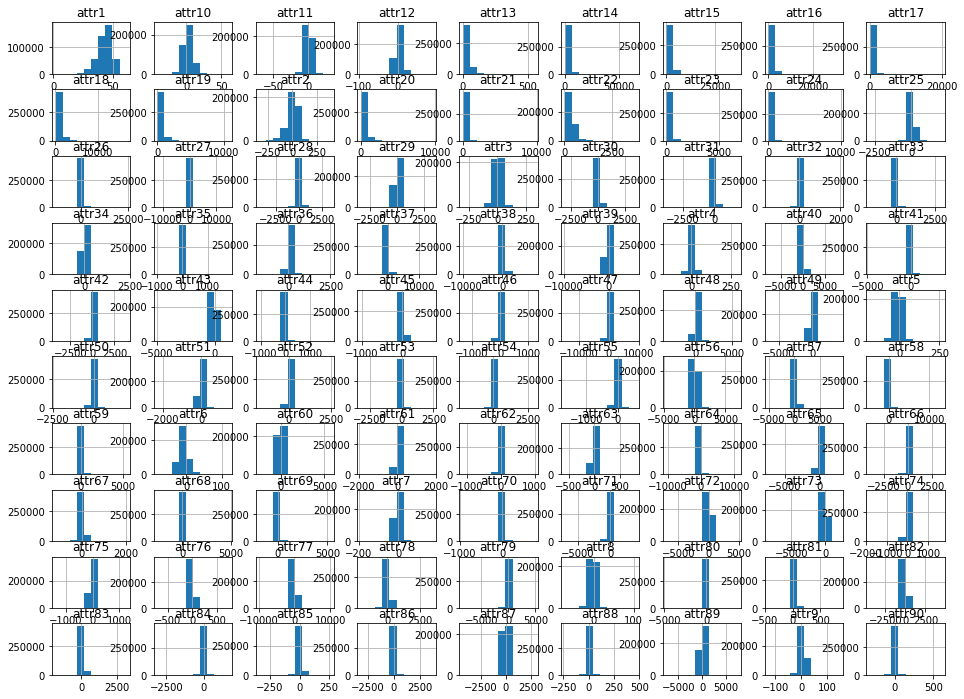

In [20]:
# Histograms for each attribute
x_train_df.hist()
pyplot.show()

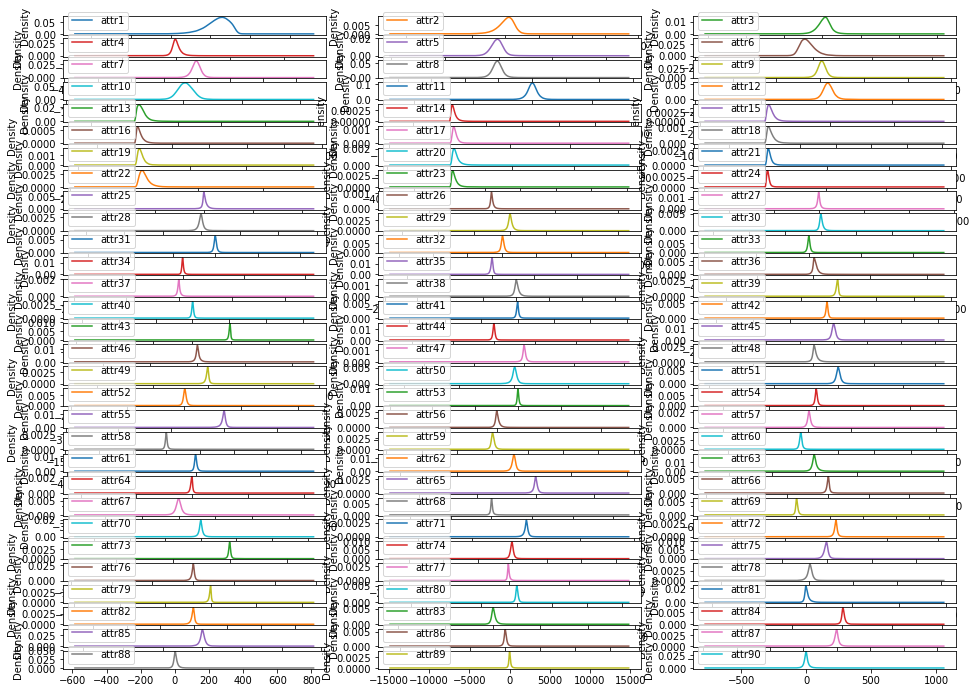

In [21]:
# Density plot for each attribute
x_train_df.plot(kind='density', subplots=True, layout=(dispRow,dispCol), sharex=False, sharey=False)
pyplot.show()

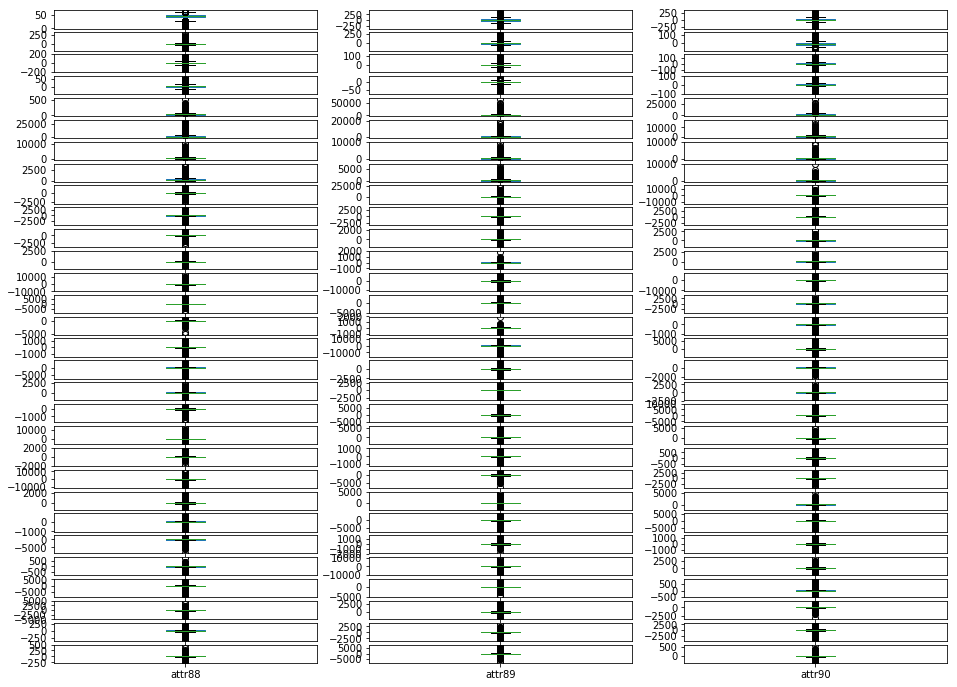

In [22]:
# Box and Whisker plot for each attribute
x_train_df.plot(kind='box', subplots=True, layout=(dispRow,dispCol), sharex=False, sharey=False)
pyplot.show()

#### 2.b.ii) Multivariate plots to better understand the relationships between attributes

In [23]:
# Scatterplot matrix
# scatter_matrix(x_train_df)
# pyplot.show()

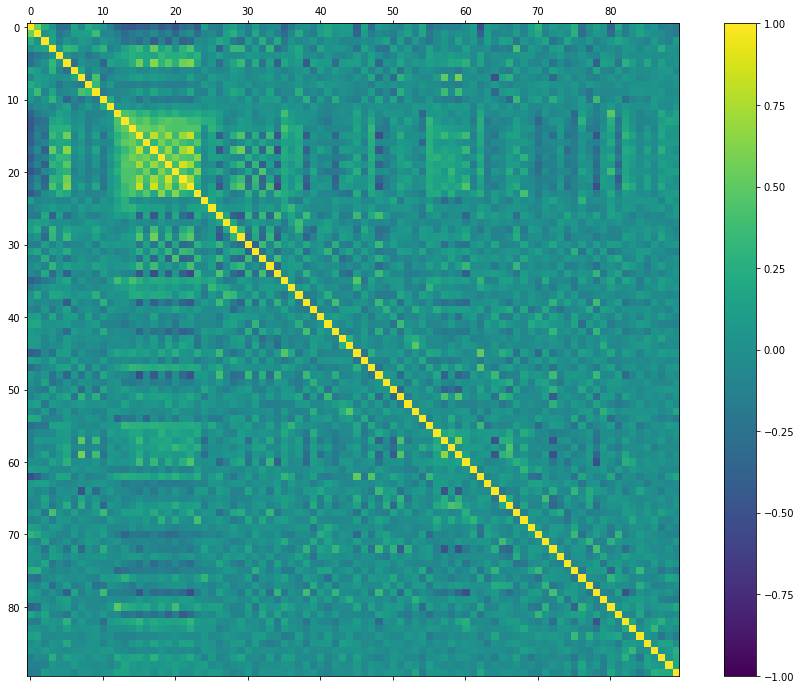

In [24]:
# Correlation matrix
fig = pyplot.figure()
ax = fig.add_subplot(111)
correlations = x_train_df.corr(method='pearson')
cax = ax.matshow(correlations, vmin=-1, vmax=1)
fig.colorbar(cax)
pyplot.show()

In [25]:
email_notify("Data Summarization and Visualization completed! "+datetime.now().strftime('%a %B %d, %Y %I:%M:%S %p'))

## Section 3 - Prepare Data
Some dataset may require additional preparation activities that will best exposes the structure of the problem and the relationships between the input attributes and the output variable. Some data-prep tasks might include:

* Cleaning data by removing duplicates, marking missing values and even imputing missing values.
* Feature selection where redundant features may be removed.
* Data transforms where attributes are scaled or redistributed in order to best expose the structure of the problem later to learning algorithms.

In [26]:
email_notify("Data Cleaning and Transformation has begun! "+datetime.now().strftime('%a %B %d, %Y %I:%M:%S %p'))

### 3.a) Data Cleaning

In [27]:
# Not applicable for this iteration of the project

### 3.b) Feature Selection

In [28]:
# Not applicable for this iteration of the project

### 3.c) Data Transforms

In [29]:
# Not applicable for this iteration of the project

### 3.d) Display the Final Datasets for Model-Building

In [30]:
# We finalize the training and testing datasets for the modeling activities
x_train = x_train_df.values
y_train = y_train_df.values
x_test = x_test_df.values
y_test = y_test_df.values
print("x_train.shape: {} y_train.shape: {}".format(x_train.shape, y_train.shape))
print("x_test.shape: {} y_test.shape: {}".format(x_test.shape, y_test.shape))
email_notify("Data Cleaning and Transformation completed! "+datetime.now().strftime('%a %B %d, %Y %I:%M:%S %p'))

x_train.shape: (463715, 90) y_train.shape: (463715,)
x_test.shape: (51630, 90) y_test.shape: (51630,)


## 4. Model and Evaluate Algorithms
After the data-prep, we next work on finding a workable model by evaluating a subset of machine learning algorithms that are good at exploiting the structure of the training. The typical evaluation tasks include:

* Defining test options such as cross validation and the evaluation metric to use.
* Spot checking a suite of linear and nonlinear machine learning algorithms.
* Comparing the estimated accuracy of algorithms.

For this project, we will evaluate one linear, two non-linear and four ensemble algorithms:

Linear Algorithm: Linear Discriminant Analysis

Non-Linear Algorithms: Decision Trees (CART) and k-Nearest Neighbors

Ensemble Algorithms: Bagged Decision Trees, Random Forest, Extra Trees, and eXtreme Gradient Boosting

The random number seed is reset before each run to ensure that the evaluation of each algorithm is performed using the same data splits. It ensures the results are directly comparable.

### 4.a) Set test options and evaluation metric

In [31]:
# Run algorithms using 10-fold cross validation
num_folds = 10
scoring = 'accuracy'

In [32]:
# Set up Algorithms Spot-Checking Array
models = []
models.append(('LDA', LinearDiscriminantAnalysis()))
models.append(('CART', DecisionTreeClassifier(random_state=seedNum)))
models.append(('KNN', KNeighborsClassifier(n_jobs=cpu_num)))
models.append(('BT', BaggingClassifier(random_state=seedNum, n_jobs=cpu_num)))
models.append(('RF', RandomForestClassifier(random_state=seedNum, n_jobs=cpu_num)))
models.append(('ET', ExtraTreesClassifier(random_state=seedNum, n_jobs=cpu_num)))
models.append(('XGB', XGBClassifier(random_state=seedNum, n_jobs=cpu_num)))
results = []
names = []
metrics = []

In [33]:
# Generate model in turn
for name, model in models:
	email_notify("Algorithm "+name+" modeling has begun! "+datetime.now().strftime('%a %B %d, %Y %I:%M:%S %p'))
	startTimeModule = datetime.now()
	kfold = KFold(n_splits=num_folds, random_state=seedNum)
	cv_results = cross_val_score(model, x_train, y_train, cv=kfold, scoring=scoring)
	results.append(cv_results)
	names.append(name)
	metrics.append(cv_results.mean())
	msg = "%s: %f (%f)" % (name, cv_results.mean(), cv_results.std())
	print(msg)
	print ('Model training time:',(datetime.now() - startTimeModule))
	email_notify("Algorithm "+name+" modeling completed! "+datetime.now().strftime('%a %B %d, %Y %I:%M:%S %p'))
print ('Average metrics ('+scoring+') from all models:',np.mean(metrics))

LDA: 0.605126 (0.010518)
Model training time: 0:01:01.914748
CART: 0.484319 (0.005947)
Model training time: 0:21:32.777071
KNN: 0.506654 (0.009370)
Model training time: 1:01:05.067878
BT: 0.586750 (0.008947)
Model training time: 0:32:39.849486
RF: 0.579671 (0.009571)
Model training time: 0:03:54.974264
ET: 0.572045 (0.009205)
Model training time: 0:02:02.450960
XGB: 0.618231 (0.011953)
Model training time: 2:43:13.341517
Average metrics (accuracy) from all models: 0.564685214682496


### 4.b) Spot-checking baseline algorithms

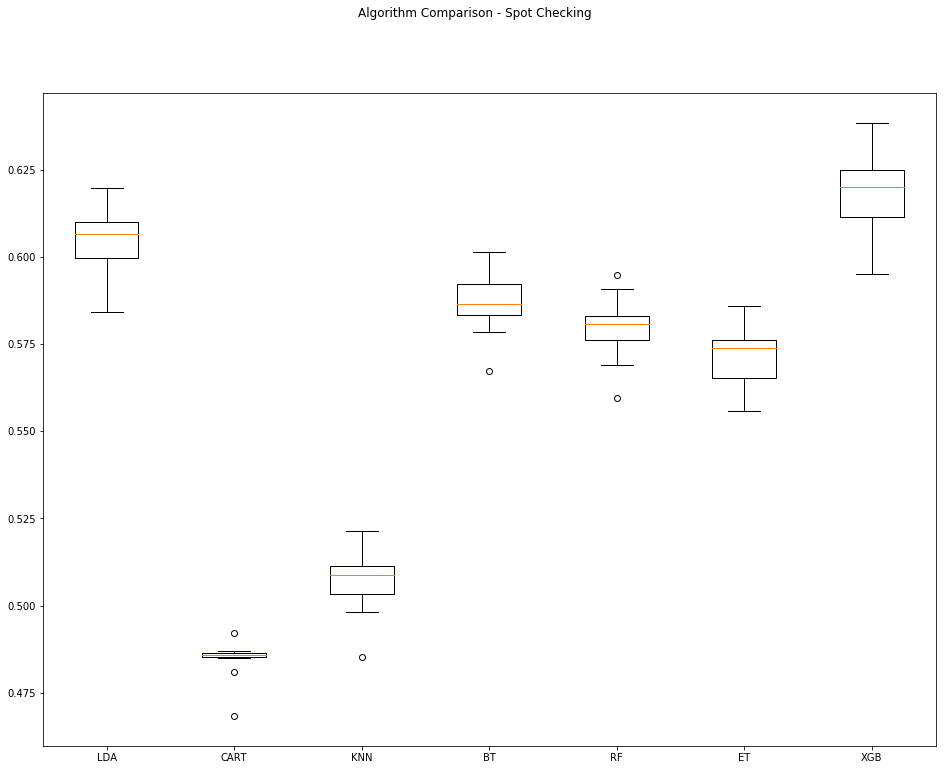

In [34]:
fig = pyplot.figure()
fig.suptitle('Algorithm Comparison - Spot Checking')
ax = fig.add_subplot(111)
pyplot.boxplot(results)
ax.set_xticklabels(names)
pyplot.show()

## Section 5 - Improve Accuracy
After we achieve a short list of machine learning algorithms with good level of accuracy, we can leverage ways to improve the accuracy of the models.

### 5.a) Algorithm Tuning

In [35]:
# Set up the comparison array
results = []
names = []

In [36]:
# Tuning algorithm #1 - Linear Discriminant Analysis
email_notify("Algorithm #1 tuning has begun! "+datetime.now().strftime('%a %B %d, %Y %I:%M:%S %p'))
startTimeModule = datetime.now()
paramGrid1 = dict(n_components=np.array([3,6,9]))
model1 = LinearDiscriminantAnalysis()
kfold = KFold(n_splits=num_folds, random_state=seedNum)
grid1 = GridSearchCV(estimator=model1, param_grid=paramGrid1, scoring=scoring, cv=kfold)
grid_result1 = grid1.fit(x_train, y_train)

print("Best: %f using %s" % (grid_result1.best_score_, grid_result1.best_params_))
results.append(grid_result1.cv_results_['mean_test_score'])
names.append('LDA')
means = grid_result1.cv_results_['mean_test_score']
stds = grid_result1.cv_results_['std_test_score']
params = grid_result1.cv_results_['params']
for mean, stdev, param in zip(means, stds, params):
    print("%f (%f) with: %r" % (mean, stdev, param))
print ('Model training time:',(datetime.now() - startTimeModule))
email_notify("Algorithm #1 tuning completed! "+datetime.now().strftime('%a %B %d, %Y %I:%M:%S %p'))

Best: 0.605126 using {'n_components': 3}
0.605126 (0.010518) with: {'n_components': 3}
0.605126 (0.010518) with: {'n_components': 6}
0.605126 (0.010518) with: {'n_components': 9}
Model training time: 0:04:05.350991


In [37]:
# Tuning algorithm #2 - eXtreme Gradient Boosting
email_notify("Algorithm #2 tuning has begun! "+datetime.now().strftime('%a %B %d, %Y %I:%M:%S %p'))
startTimeModule = datetime.now()
paramGrid2 = dict(n_estimators=np.array([100,300,500]))
model2 = XGBClassifier(random_state=seedNum, n_jobs=cpu_num)
kfold = KFold(n_splits=num_folds, random_state=seedNum)
grid2 = GridSearchCV(estimator=model2, param_grid=paramGrid2, scoring=scoring, cv=kfold)
grid_result2 = grid2.fit(x_train, y_train)

print("Best: %f using %s" % (grid_result2.best_score_, grid_result2.best_params_))
results.append(grid_result2.cv_results_['mean_test_score'])
names.append('XGB')
means = grid_result2.cv_results_['mean_test_score']
stds = grid_result2.cv_results_['std_test_score']
params = grid_result2.cv_results_['params']
for mean, stdev, param in zip(means, stds, params):
    print("%f (%f) with: %r" % (mean, stdev, param))
print ('Model training time:',(datetime.now() - startTimeModule))
email_notify("Algorithm #2 tuning completed! "+datetime.now().strftime('%a %B %d, %Y %I:%M:%S %p'))

Best: 0.638526 using {'n_estimators': 500}
0.618231 (0.011953) with: {'n_estimators': 100}
0.634049 (0.010278) with: {'n_estimators': 300}
0.638526 (0.009891) with: {'n_estimators': 500}
Model training time: 1 day, 5:01:23.907417


### 5.b) Compare Algorithms After Tuning

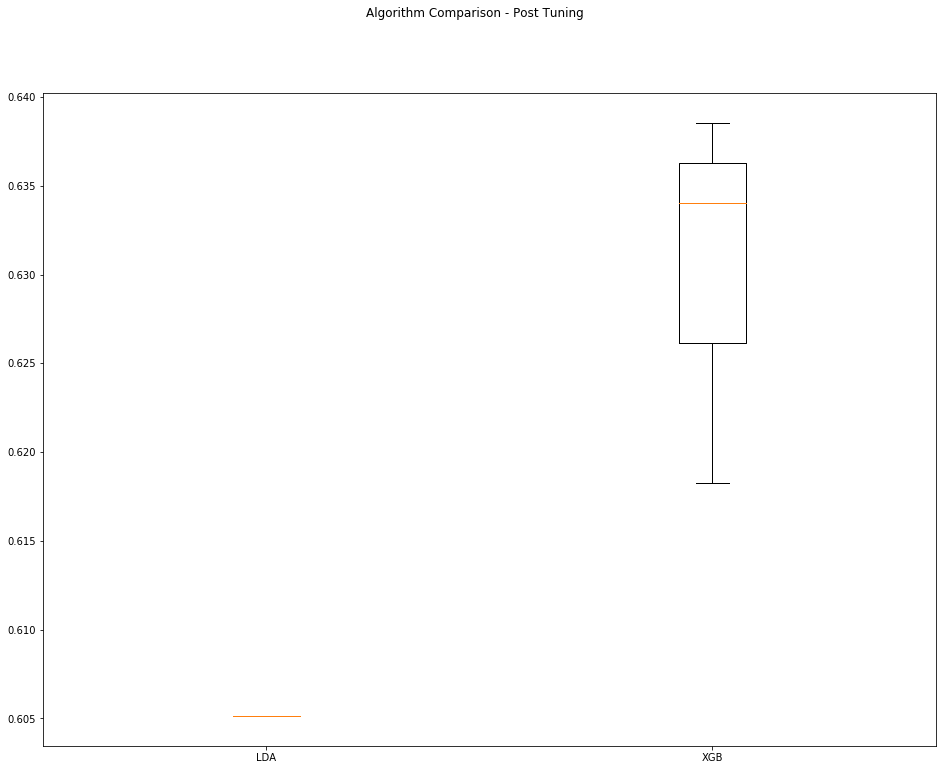

In [38]:
fig = pyplot.figure()
fig.suptitle('Algorithm Comparison - Post Tuning')
ax = fig.add_subplot(111)
pyplot.boxplot(results)
ax.set_xticklabels(names)
pyplot.show()

## Section 6 - Finalize Model
Once we have narrow down to a model that we believe can make accurate predictions on unseen data, we are ready to finalize it. Finalizing a model may involve sub-tasks such as:
* Using an optimal model tuned to make predictions on unseen data.
* Creating a standalone model using the tuned parameters
* Saving an optimal model to file for later use.

In [39]:
email_notify("Model Validation and Final Model Creation has begun! "+datetime.now().strftime('%a %B %d, %Y %I:%M:%S %p'))

### 6.a) Predictions on validation dataset

In [40]:
model = XGBClassifier(random_state=seedNum, n_jobs=cpu_num, n_estimators=500)
model.fit(x_train, y_train)
predictions = model.predict(x_test)
print(accuracy_score(y_test, predictions))
print(confusion_matrix(y_test, predictions))
print(classification_report(y_test, predictions))

0.636548518303312
[[    0     0     0     0     0     0     0    18     2     0]
 [    0     0     0     0     0     0     0    13     0     0]
 [    0     1     0     0     0     0     0    47    13     0]
 [    0     0     0     1    13     4     4   136   117     0]
 [    0     0     0     0    48    65    53   463   537     0]
 [    0     0     0     0    14   255   103   764  1260     0]
 [    0     0     0     2     9    80   839  1648  1623     0]
 [    2     1     0     0    24   107   341  4393  7712     0]
 [    3     0     0     2    30   121   164  2236 27329     0]
 [    0     0     0     0     0     1     7    56   969     0]]
              precision    recall  f1-score   support

           0       0.00      0.00      0.00        20
           1       0.00      0.00      0.00        13
           2       0.00      0.00      0.00        61
           3       0.20      0.00      0.01       275
           4       0.35      0.04      0.07      1166
           5       0.40   

/home/dlowe/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


### 6.b) Create standalone model on entire training dataset

In [41]:
startTimeModule = datetime.now()

# Combining the training and testing datasets to form the complete dataset that will be used for training the final model
x_complete = np.vstack((x_train, x_test))
y_complete = np.concatenate((y_train, y_test))
print("x_complete.shape: {} y_complete.shape: {}".format(x_complete.shape, y_complete.shape))

finalModel = XGBClassifier(random_state=seedNum, n_jobs=cpu_num, n_estimators=500)
finalModel.fit(x_complete, y_complete)
print ('Model training time:',(datetime.now() - startTimeModule))

x_complete.shape: (515345, 90) y_complete.shape: (515345,)
Model training time: 2:02:18.248540


### 6.c) Save model for later use

In [42]:
# modelName = 'finalModel_BinaryClass.sav'
# dump(finalModel, modelName)

In [43]:
print ('Total time for the script:',(datetime.now() - startTimeScript))

Total time for the script: 1 day, 13:58:44.957995


In [44]:
email_notify("Model Validation and Final Model Creation completed! "+datetime.now().strftime('%a %B %d, %Y %I:%M:%S %p'))